# Setup

In [24]:
import pysam
from intervaltree import IntervalTree
from collections import defaultdict
import os

In [ ]:
# Load input files
result_fn = "../../PCR2_pool1/NanoSplicer_out/output.tsv"
result_f = open(result_fn, 'r')

# Read lines from NanoSplicer output
# return 
    #1. minimap: minimap supported junction
    #2. candidaite: all candidate junctions
    #3. NanoSplicer: indicate which candidate is selected by NanoSplicer (0-base int)
    #4. min_score: S_i
def parse_result_line(line):
    minimap, candidates, NanoSplicer, min_score = line.split()
    minimap = tuple([int(x) for x in minimap.split(',')])
    candidates = [int(i) for i in candidates.split(',')]
    candidates = [(candidates[i], candidates[i+1])
                  for i in range(0,len(candidates),2)]
    NanoSplicer            = int(NanoSplicer)
    min_score = float(min_score)
    return minimap, candidates, NanoSplicer, min_score

In [12]:
# Get prop of NanoSplicer results match minimap2
# output:
    # 1. total: total number of squiggles/junction within reads
    # 2. prop: prop of NanoSplicer results match minimap2
    # 3. match_score: list of S_i for matched squiggle
    # 4. mismatch_score list of S_i for mismatched squiggle
def minimap_nanosplicer_campare(result_fn):
    with open(result_fn, 'r') as f:
        total = 0
        match = 0
        match_score = []
        mismatch_score =[]
        for line in f:
            total += 1
            minimap, candidates, NanoSplicer, min_score\
                                         = parse_result_line(line)
            if minimap == candidates[NanoSplicer]:
                match += 1
                if min_score < 100:
                    match_score.append(min_score)
            elif min_score < 100:
                mismatch_score.append(min_score)
    prop = match/total
    return total, prop, match_score,mismatch_score

In [20]:
# check minimap2/NanoSplicer result with short read supported junctions
# input:
    # 1. result_fn: filename for nanoSplicer output
    # 2. find_intron_result: pysam.find_intron result from short read.bam
    # 3. max_S_i: threshold for S_i
    # 4. short_thres: thershold for short read support

# output:
    # 1. minimap_match: list, number of short read support for each junction within read
    # 2. NanoSplicer_match: list, number of short read support for each squiggle
    # 3. num_junction_supported: number of junctions have short reads support.
def to_short_read_compare(result_fn, find_intron_result):
    with open(result_fn, 'r') as f:
        S_is = []
        minimap_match = []
        NanoSplicer_match = []
        num_junction_supported = []
        for line in f:
            minimap, candidates, NanoSplicer,S_i\
                                 = parse_result_line(line)
            S_i
            minimap_match.append(find_intron_result.get(minimap, 0))
            NanoSplicer_match.append(find_intron_result.get(candidates[NanoSplicer], 0))
            num_junction_supported.append(len(set(candidates).intersection(set(find_intron_result.keys()))))
    return minimap_match, NanoSplicer_match ,num_junction_supported

# Analysis

## Distribution of S_i

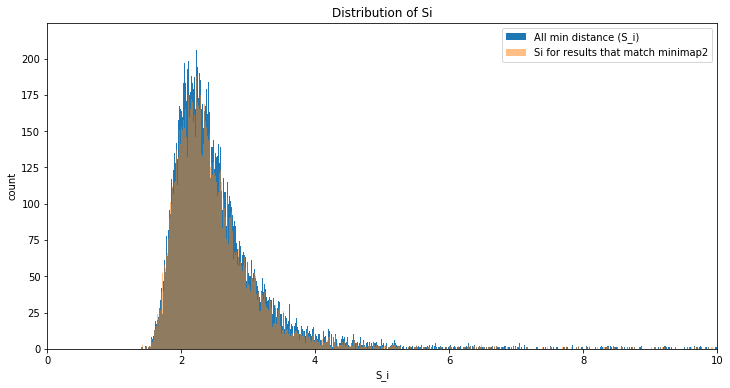

In [19]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
total, match, match_score,mismatch_score = \
                    minimap_nanosplicer_campare(result_fn)

plt.hist(match_score + mismatch_score, bins = 10000, alpha = 1)
plt.hist(match_score , bins = 10000, alpha = 0.5)
plt.xlim((0,10))
plt.legend(['All min distance (S_i)','Si for results that match minimap2'])
plt.xlabel('S_i')
plt.ylabel('count')
plt.title('Distribution of Si')
plt.show()
plt.close()

## Short reads vs Long read Comparison

In [ ]:
# Load BAM file
BAM_FN = 'BAM/Chr_ID/NC_000001.11.bam'
SHORT_READ_no_anno = '/data/cephfs/punim0614/shared/shared_data/'\
                    'external_public/RNASeqMixology/splice_site_analysis/'\
                    'GRCh38_bam_no_annotation/SRR1706863_1Aligned.sortedByCoord.out.bam'
SHORT_READ_anno = '/data/cephfs/punim0614/shared/shared_data/external_public/'\
                    'RNASeqMixology/splice_site_analysis/GRCh38_bam_with'\
                    '_ncbi_annotation/SRR1706783_1Aligned.sortedByCoord.out.bam'
REF_FN = '/data/cephfs/punim0614/shared/shared_data/external_public/' \
            'RNASeqMixology/splice_site_analysis/GRCh38_latest_genomic.fna'

    # read .bam and .fa using pysam
fbam = pysam.AlignmentFile(BAM_FN)
f_short_anno = pysam.AlignmentFile(SHORT_READ_anno)
f_short_no_anno = pysam.AlignmentFile(SHORT_READ_no_anno)
fref = pysam.FastaFile(REF_FN)

chrID = 'NC_000001.11'
f_fetch = fbam.fetch(chrID) # reads iterator
f_short_anno_fetch = f_short_anno.fetch(chrID)
f_short_no_anno_fetch = f_short_no_anno.fetch(chrID)

f_introns = fbam.find_introns(f_fetch) # dictionary
f_short_anno_fetch_intron = f_short_anno.find_introns(f_short_anno_fetch)
f_short_no_anno_fetch_intron = f_short_no_anno.find_introns(f_short_no_anno_fetch)
